# Doppler Shift

We take $v_{out}$ with $v_{rot_0} = 0$ km/s. Then we Doppler shift it to reproduce $v_{out}$ with $v_{rot}$. The combinations for each of the 3 taus are:

* $v_{rot} = 50$ km/s and $v_{out} = 25$ km/s
* $v_{rot} = 50$ km/s and $v_{out} = 50$ km/s
* $v_{rot} = 50$ km/s and $v_{out} = 75$ km/s -> data vout=75?
* $v_{rot} = 100$ km/s and $v_{out} = 25$ km/s
* $v_{rot} = 100$ km/s and $v_{out} = 50$ km/s
* $v_{rot} = 100$ km/s and $v_{out} = 75$ km/s -> data vout=75?

This is an example:

![example](../../paper/figures/rotation_doppler_outflow.png)

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
import os
%matplotlib inline

In [2]:
def read_data(vrot=0, vout=5, logtau=5, input_dir="../../data/"):
    tau_name = 'tau10E' + str(logtau)
    vrot_name = 'vrot' + str(vrot)
    vout_name = 'vout' + str(vout)
    filename = tau_name + '_' + vrot_name + '_' + vout_name + '_out.ascii'
    fname =  os.path.join(input_dir, tau_name, vrot_name, vout_name, filename)

    dtype=[('x', 'f8'),('y', 'f8'), ('z', 'f8'),
           ('k_x', 'f8'),('k_y', 'f8'),('k_z', 'f8'),
           ('x_frec', 'f8'), ('escaped', 'i8'), ('n_scattering', 'i8')]

    df = np.loadtxt(fname, skiprows=1, dtype=dtype)
    df = df[df['escaped']==0]
    return df

In [90]:
def get_angles(num_thetas, num_phis):
    '''Get the angles'''
    cos_thetas = np.linspace(0,1,num_thetas+1) 
    cos_thetas_plus = np.linspace(-1,0,num_thetas+1)
    thetas = np.sort(np.arccos(cos_thetas))
    thetas_plus = np.arccos(cos_thetas_plus)
    phis = np.linspace(0,2*np.pi,num_phis+1) 
    return thetas, thetas_plus, phis

def get_unit_r_sphere(data):
    '''Re-scale positions on the sphere at which the photons escaped'''
    r_norm = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
    x_sphere = data['x'] / r_norm
    y_sphere = data['y'] / r_norm
    z_sphere = data['z'] / r_norm
    return x_sphere, y_sphere, z_sphere

# Auxiliar functions

def filter_by_theta(data, theta_min, theta_max):
    '''Return only the x_frec_escaped between those upper and lower angles'''
    
    cos_theta_k_out = np.abs(data['k_z'])
    ii = (cos_theta_k_out<np.abs(np.cos(theta_min))) 
    ii = ii &   (cos_theta_k_out>np.abs(np.cos(theta_max)))
    print(np.cos(theta_min))
    return data[ii]

def get_atom_velocities(x_unitary, y_unitary, z_unitary, vrot):
    '''Defines new atom velocities based on vrot (vr) '''
    v_x = - y_unitary*vrot
    v_y = x_unitary*vrot
    v_z = np.zeros(len(z_unitary))
    return {'x':v_x, 'y':v_y, 'z':v_z}

def doppler_shift(data, vrot=0.0, v_th=12.86):
    '''updates old_data adding doppler shifts. the result is stored in new_data'''
    
    new_data = data.copy()
    
    new_data['x'], new_data['y'], new_data['z'] = get_unit_r_sphere(data)
    
    atom_velocities = get_atom_velocities(
                        new_data['x'], new_data['y'], new_data['z'], vrot=vrot)
    
    #line of sight unit vectors
    los_vector = data[['k_x', 'k_y', 'k_z']]
    
    new_data['x_frec'] = data['x_frec'] 
    new_data['x_frec'] += atom_velocities['x']*data['k_x']/v_th
    new_data['x_frec'] += atom_velocities['y']*data['k_y']/v_th
    new_data['x_frec'] += atom_velocities['z']*data['k_z']/v_th
    
    return new_data

In [91]:
print(np.count_nonzero(filter_by_theta(data_B, 1.4, 3.14)))
ll = get_unitary_vectors(filter_by_theta(data_B, 0.0, 0.08))
#print(ll['z'])
nn = doppler_shift(data_B, vrot=10.0)
print(nn[0:10])
new_data = doppler_shift(data_A, vrot=100)

0.1699671429
0
1.0
[ (-0.7586647412878853, -0.1252641565875112, -0.6393251922152025, -0.7199572, 0.4201132, -0.5524188, 0.4656720239294465, 0, 83344)
 (-0.8908017178730516, -0.38730958183163483, 0.23762067935224865, -0.9205007, -0.3894241, -0.03205263, -5.752148847536206, 0, 34125)
 (-0.07062913540662742, -0.20500861994246233, -0.9762084772122189, -0.1137064, -0.3472096, -0.9308686, -4.176441292604778, 0, 106679)
 (0.5878987503659059, 0.6618655967340056, 0.46509030432610066, 0.5497871, 0.6867492, 0.4755099, -4.140159463859543, 0, 259297)
 (-0.21417926157307485, -0.7339722065340542, -0.644524665119609, -0.2196446, -0.7383701, -0.6376251, 4.290137165684563, 0, 16290)
 (-0.5166541435995966, -0.8509412176100339, 0.09469709643764308, -0.5174929, -0.8545375, -0.04434769, -3.248742185221079, 0, 45524)
 (-0.0025129062911569714, -0.5400194256812569, -0.8416488015727566, 0.1359066, -0.5822702, -0.8015552, -5.73607207268505, 0, 20514)
 (-0.10341265849827379, 0.3496857862746258, 0.9311421335863909

In [137]:
def plot_spectra(data, min_theta, max_theta, alpha=1.0, v_th=12.86, lw=2,label='label'):
    data_theta = filter_by_theta(data, min_theta, max_theta)
    a = plt.hist(data_theta['x_frec']*v_th, histtype='step', 
                 fill=False, stacked=False, normed=True, color='black',
                 linewidth=lw, bins=50, alpha=alpha, label=label)

In [119]:
# We are going to transform data_A to rewrite data_C and compare it against data_B
data_A = read_data(vout=5, vrot=0, logtau=5)
data_B = read_data(vout=5, vrot=100, logtau=5)
data_C = doppler_shift(data_A, vrot=100.0)
#data_C = read_data(vout=0, vrot=100, logtau=6)
#../../data/tau10E5/vrot0/vout5/tau10E5_vrot0_vout5_out.ascii

0.0499791692707
0.0499791692707
0.0499791692707


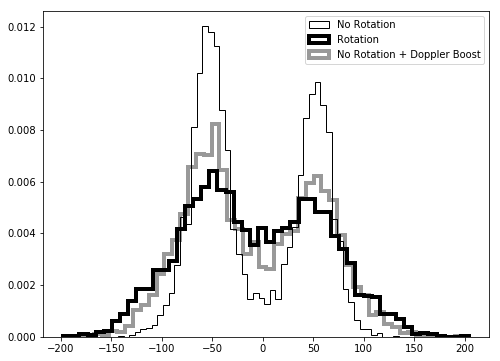

In [140]:
fig = plt.figure(1, (8., 6.))
mint= np.pi/2.0 -0.05
maxt = np.pi/2.0
plot_spectra(data_A, min_theta=mint, max_theta=maxt, lw=1, label='No Rotation')
plot_spectra(data_B, min_theta=mint, max_theta=maxt, lw=4, label='Rotation')
plot_spectra(data_C, min_theta=mint, max_theta=maxt, lw=4, alpha=0.4, 
            label='No Rotation + Doppler Boost')
plt.legend()

0.0998334166468
0.0998334166468
0.0998334166468


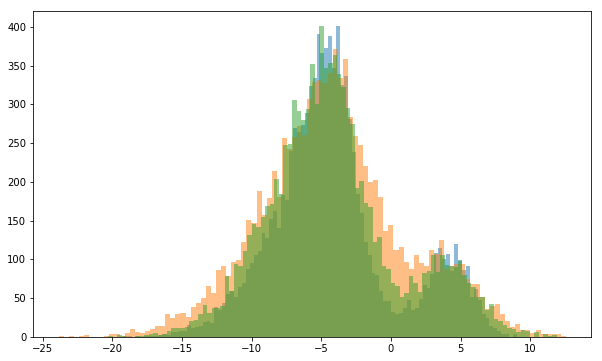

In [97]:
fig = plt.figure(1, (10., 6.))
plot_spectra(data_A, min_theta=np.pi/2.0 -0.1, max_theta=np.pi/2.0, alpha=0.5)
plot_spectra(data_B, min_theta=np.pi/2.0 -0.1, max_theta=np.pi/2.0, alpha=0.5)
plot_spectra(data_C, min_theta=np.pi/2.0 -0.1, max_theta=np.pi/2.0, alpha=0.5)